### Import Dependencies

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.metrics import classification_report ,ConfusionMatrixDisplay ,confusion_matrix
from keras import layers
from tensorflow.keras.callbacks import TensorBoard
sns.set_theme(style='white')
import datetime 
import pandas as pd
import random
random.seed(10) #לצורך שחזור תוצאות

### Load Data Set 

העלאת הדאטא סט וקריאת החילוק המידע לפי סט אימון, סט ולידציה וסט טסט

In [2]:
def load_data(path):
    with np.load(path) as file:
        x_train, y_train = file['train_images'], file['train_labels']
        x_test, y_test = file['test_images'], file['test_labels']
        x_val, y_val = file['val_images'], file['val_labels']
        return (x_train, y_train), (x_test, y_test) , (x_val, y_val) 
    
(x_train, y_train), (x_test, y_test),(x_val ,y_val) = load_data('bloodmnist.npz')

### Data Set Description

הדפסת המימדים של התמונות והגדלים של כל סט

In [3]:
## Data Set Dimensions
print('Image Dim: {} x {}'.format(x_train.shape[1],  x_train.shape[2]))
print('Training: {} / Validation: {} / Test: {} /Total: {}'.format(x_train.shape[0],x_val.shape[0],x_test.shape[0],np.sum([x_train.shape[0],x_val.shape[0],x_test.shape[0]])))

Image Dim: 28 x 28
Training: 11959 / Validation: 1712 / Test: 3421 /Total: 17092


הצגת היסטוגרמה של סט אימון,ולידציה וטסט

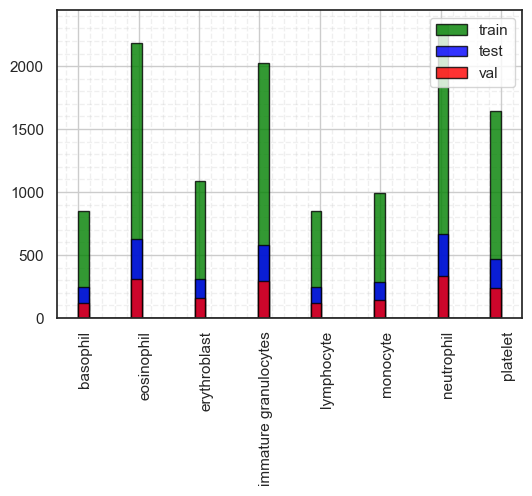

In [4]:
fig, ax = plt.subplots(figsize=(6,4))

class_names=["basophil","eosinophil","erythroblast","immature granulocytes","lymphocyte","monocyte","neutrophil","platelet"]
c= ['green','blue','red']
label = ['train','test','val']

for idx ,a in enumerate([y_train, y_test,y_val]):
    ax.hist(a,color=c[idx],bins=40 ,label=label[idx],edgecolor='black',alpha=0.8)
    ax.grid(visible=True ,which='minor',linestyle='--',alpha=0.3)
    ax.minorticks_on()
    ax.grid()
plt.xticks(ticks=range(8), labels=class_names, rotation=90, horizontalalignment='left')
plt.legend()
plt.show()

הדפסה של התמונות הראשונות וקיטלוג לפי הקטגוריות

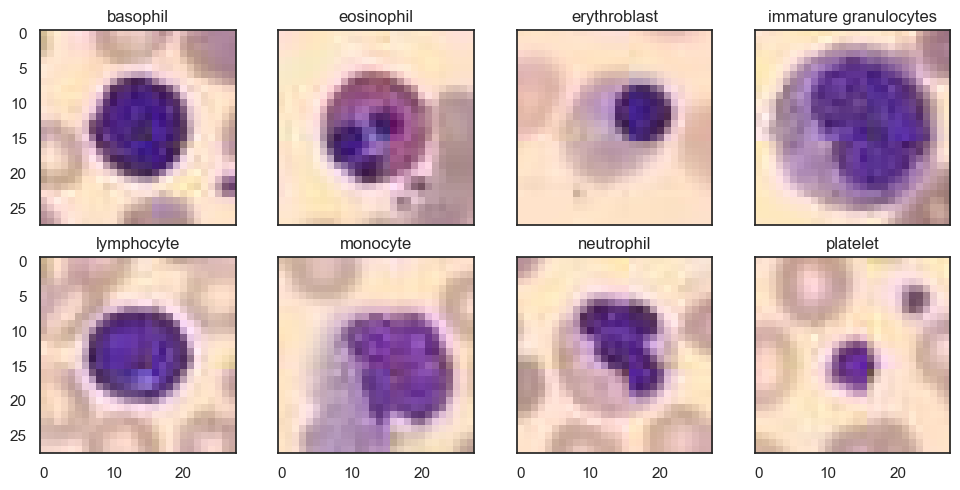

In [6]:
# plot first few images
valueList, indicesList = np.unique(y_train, return_index=True)
fig, ax = plt.subplots(2,4,figsize=(10,5),sharex=True ,sharey=True)
for i,idx in enumerate(indicesList):
    if i <=3:
        ax[0,i].imshow(x_train[idx], cmap=plt.cm.binary)
        ax[0,i].set_title(class_names[i])
    else:
        ax[1,i-4].imshow(x_train[idx], cmap=plt.cm.binary)
        ax[1,i-4].set_title(class_names[i])
            
plt.tight_layout()
plt.show()

### Data preprocces

נרמול הדאטה בין 0 ל 1 

In [8]:
#normalization 
X_train = (x_train.astype('float64')/255).reshape((-1, 28, 28, 3))
X_val = (x_val.astype('float64')/255).reshape((-1, 28, 28, 3))
X_test = (x_test.astype('float64')/255).reshape((-1, 28, 28, 3))
print('Training: {} / Validation: {} / Test: {} /Total: {}'.format(X_train.shape[0],X_val.shape[0],X_test.shape[0],np.sum([X_train.shape[0],X_val.shape[0],X_test.shape[0]])))

Training: 11959 / Validation: 1712 / Test: 3421 /Total: 17092


פונקציות ציור ופונקצאת התאמה לצורך מימוש של מטריקות על ידי שימוש בספריית לימוד מכונה

In [9]:
def evaluation_plots(classifier):
    losses = pd.DataFrame(classifier.history.history)
    fig,axs =plt.subplots(1,2,figsize=(12,4))
    axs[0].plot(losses[['loss','val_loss']],label=['Train_loss' ,'Val_loss'])
    axs[1].plot(losses[['accuracy','val_accuracy']],label=['Train_accuracy' ,'Val_accuracy'])
    title = ['loss','accuracy']
    for i in range(2):
        axs[i].grid(visible=True ,which='minor',linestyle='--',alpha=0.3)
        axs[i].minorticks_on()
        axs[i].grid()
        axs[i].set_xlabel('epocs')
        axs[i].set_title(title[i])
        axs[i].legend(loc='upper left')
    plt.show()
    
class estimator:
    _estimator_type = ''
    classes_=[]
    def __init__(self, model, classes):
        self.model = model
        self._estimator_type = 'classifier'
        self.classes_ = classes
    def predict(self, X):
        y_prob= self.model.predict(X)
        y_pred = y_prob.argmax(axis=1)
        return y_pred

# DNN

יצירת מודל ומספר שכבות לפי מידת הצורך

In [145]:
classifier = keras.Sequential(name='DNN-64-32_ES')
classifier.add(layers.InputLayer(input_shape=(28,28,3)))
classifier.add(layers.Flatten())
classifier.add(layers.Dense(64 ,activation='relu'))
#classifier.add(layers.Dense(64 ,activation='relu'))
#classifier.add(layers.Dense(256 ,activation='relu'))
#classifier.add(layers.Dropout(0.4))
#classifier.add(layers.Dense(256 ,activation='relu'))
#classifier.add(layers.Dense(512 ,activation='relu'))
classifier.add(layers.Dense(32 ,activation='relu'))
classifier.add(layers.Dense(8, activation='softmax'))
classifier.summary()

Model: "DNN-64-32_ES"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_26 (Flatten)        (None, 2352)              0         
                                                                 
 dense_131 (Dense)           (None, 64)                150592    
                                                                 
 dense_132 (Dense)           (None, 32)                2080      
                                                                 
 dense_133 (Dense)           (None, 8)                 264       
                                                                 
Total params: 152,936
Trainable params: 152,936
Non-trainable params: 0
_________________________________________________________________


הגדרת מיקום בו נשמרים קצבי הלוג ויצירת קולבק שנוכל להשתמש בו באימון

In [146]:
# Callback for convergence and the purpose of checking progress 
log_dir = "logs/fit_DNN/" + 'DNN-64-32_ES'
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30, verbose=1)

הגדרת מודל האימון

In [147]:
classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

אימון המודל

In [148]:
history=classifier.fit(X_train, y_train, batch_size=64, epochs=250, validation_data=(X_val,y_val),callbacks=[tb_callback,es_callback])

Epoch 1/250
187/187 [==============================] - 1s 6ms/step - loss: 1.4498 - accuracy: 0.4699 - val_loss: 1.0558 - val_accuracy: 0.6437
Epoch 2/250
187/187 [==============================] - 1s 5ms/step - loss: 0.9846 - accuracy: 0.6506 - val_loss: 0.9002 - val_accuracy: 0.6711
Epoch 3/250
187/187 [==============================] - 1s 5ms/step - loss: 0.8744 - accuracy: 0.6933 - val_loss: 0.7925 - val_accuracy: 0.7231
Epoch 4/250
187/187 [==============================] - 1s 5ms/step - loss: 0.8131 - accuracy: 0.7175 - val_loss: 0.7074 - val_accuracy: 0.7518
Epoch 5/250
187/187 [==============================] - 1s 5ms/step - loss: 0.7757 - accuracy: 0.7298 - val_loss: 0.7005 - val_accuracy: 0.7687
Epoch 6/250
187/187 [==============================] - 1s 5ms/step - loss: 0.7356 - accuracy: 0.7404 - val_loss: 0.7020 - val_accuracy: 0.7243
Epoch 7/250
187/187 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.7587 - val_loss: 0.6387 - val_accuracy: 0.7693

Epoch 58/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3957 - accuracy: 0.8518 - val_loss: 0.4617 - val_accuracy: 0.8300
Epoch 59/250
187/187 [==============================] - 1s 4ms/step - loss: 0.4048 - accuracy: 0.8508 - val_loss: 0.4189 - val_accuracy: 0.8499
Epoch 60/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3834 - accuracy: 0.8583 - val_loss: 0.4525 - val_accuracy: 0.8394
Epoch 61/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3765 - accuracy: 0.8640 - val_loss: 0.4626 - val_accuracy: 0.8277
Epoch 62/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3680 - accuracy: 0.8667 - val_loss: 0.4951 - val_accuracy: 0.8230
Epoch 63/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3904 - accuracy: 0.8553 - val_loss: 0.4287 - val_accuracy: 0.8446
Epoch 64/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3832 - accuracy: 0.8594 - val_loss: 0.4169 - val_accuracy:

Epoch 115/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3203 - accuracy: 0.8854 - val_loss: 0.4128 - val_accuracy: 0.8569
Epoch 116/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3005 - accuracy: 0.8911 - val_loss: 0.4050 - val_accuracy: 0.8674
Epoch 117/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3144 - accuracy: 0.8861 - val_loss: 0.4372 - val_accuracy: 0.8411
Epoch 118/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3115 - accuracy: 0.8862 - val_loss: 0.4074 - val_accuracy: 0.8639
Epoch 119/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3033 - accuracy: 0.8881 - val_loss: 0.4439 - val_accuracy: 0.8429
Epoch 120/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3207 - accuracy: 0.8844 - val_loss: 0.4367 - val_accuracy: 0.8616
Epoch 121/250
187/187 [==============================] - 1s 4ms/step - loss: 0.3112 - accuracy: 0.8883 - val_loss: 0.4069 - val_ac

###### הדפסת גרפים של הפסד ודיוק 

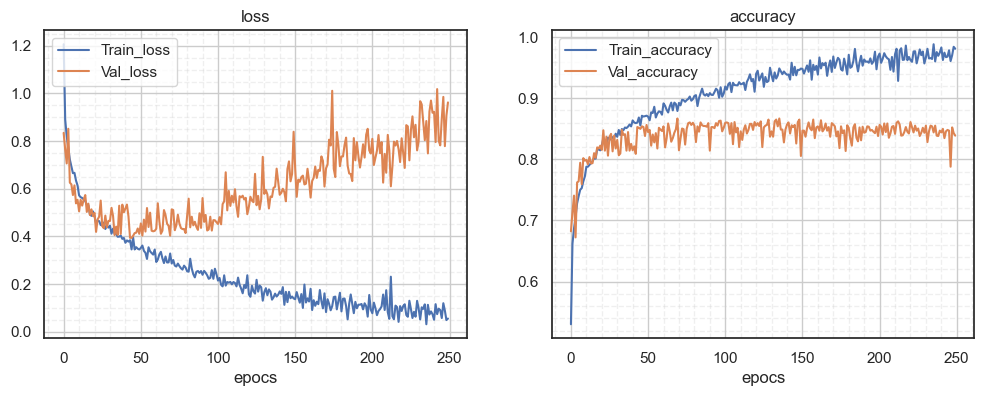

In [86]:
# DNN-128-128-256-256-512 ,No early stopping ,No dropout layers
evaluation_plots(classifier)

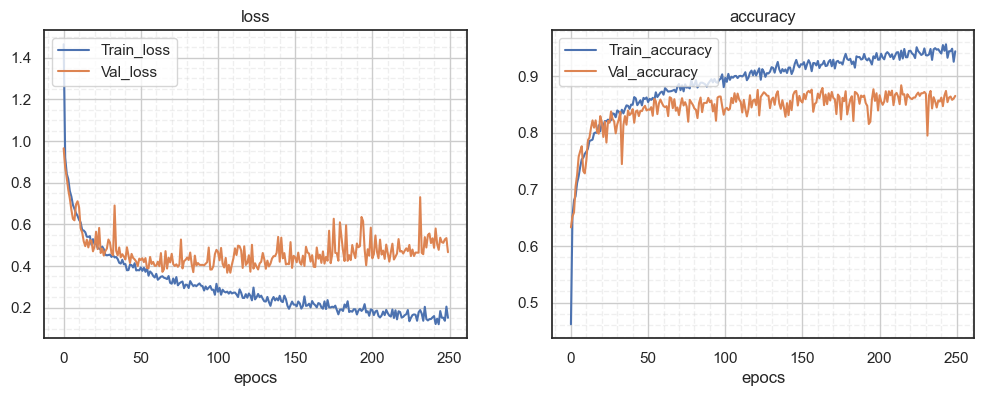

In [91]:
# DNN-64-64-64-32-32 ,No early stopping ,No dropout layers
evaluation_plots(classifier)

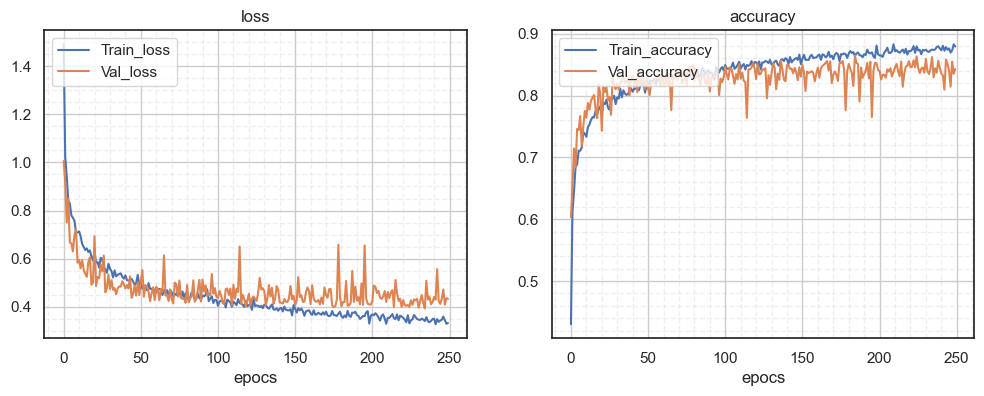

In [101]:
# 'DNN-64-64-D0.4-64-64'  ,No early stopping
evaluation_plots(classifier)

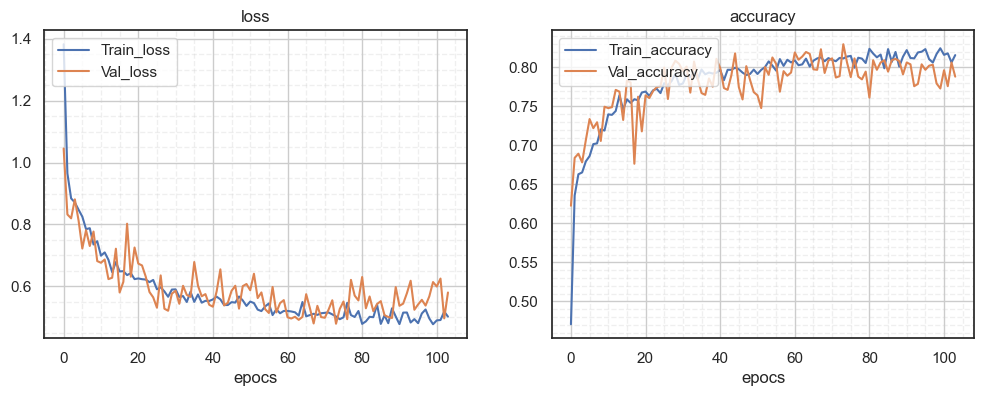

In [144]:
#'DNN-64-64-64-64_ES_tanh' ,With early stopping ,With dropout layers ,activation tanh
evaluation_plots(classifier)

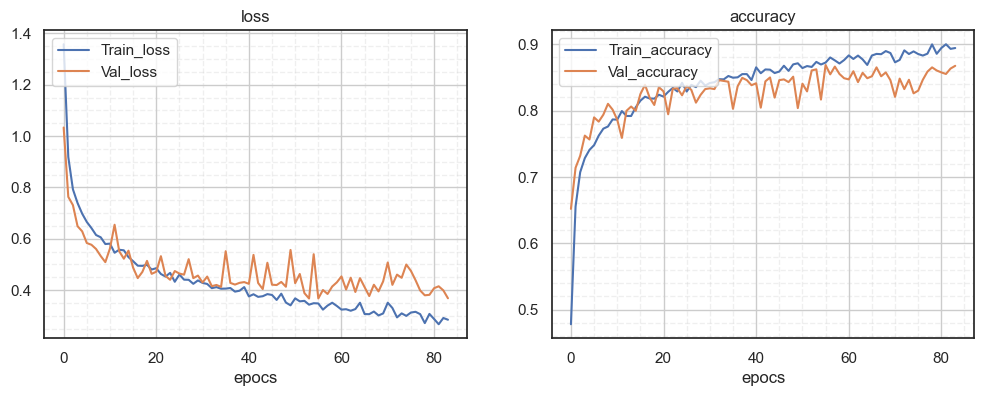

In [115]:
# DNN-64-64-64-64_ES ,With early stopping ,No dropout layers
evaluation_plots(classifier)

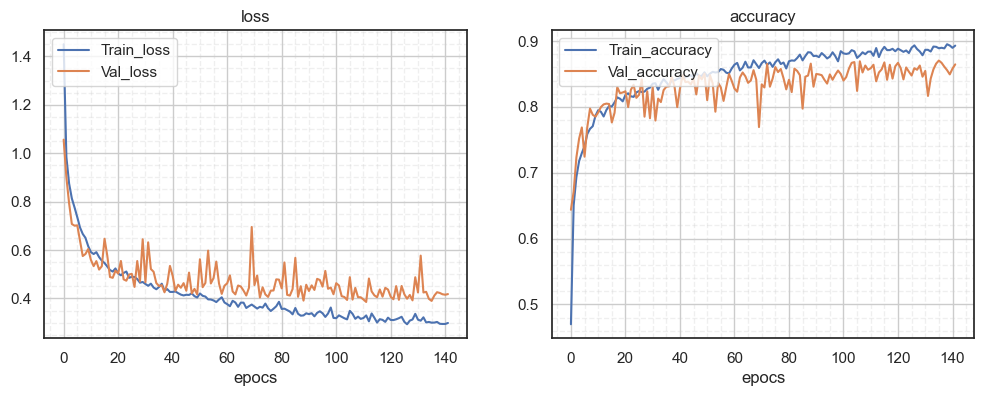

In [149]:
# 'DNN-64-32_ES' ,With early stopping 
evaluation_plots(classifier)

In [150]:
#'DNN-64-32_ES'
est = estimator(classifier, class_names)    
predicted_labels = est.predict(X_test)

107/107 [==============================] - 0s 2ms/step


In [151]:
print(classification_report(y_test ,predicted_labels ,digits=4,target_names=class_names))

                       precision    recall  f1-score   support

             basophil     0.9206    0.4754    0.6270       244
           eosinophil     0.9408    0.9679    0.9542       624
         erythroblast     0.9324    0.8424    0.8851       311
immature granulocytes     0.6203    0.8325    0.7109       579
           lymphocyte     0.8421    0.8560    0.8490       243
             monocyte     0.7650    0.5845    0.6627       284
           neutrophil     0.9274    0.9009    0.9139       666
             platelet     0.9711    1.0000    0.9853       470

             accuracy                         0.8500      3421
            macro avg     0.8650    0.8075    0.8235      3421
         weighted avg     0.8643    0.8500    0.8482      3421



הדפסת מטריצת מבוכה

107/107 [==============================] - 0s 2ms/step


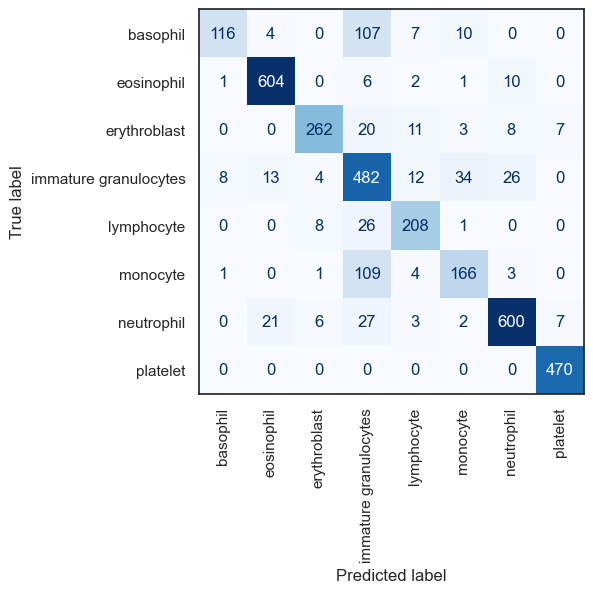

In [152]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_estimator(est,X_test,y_test,display_labels=class_names,cmap='Blues',colorbar=False,xticks_rotation=90,ax=ax)
plt.show()

## CNN

אימון המודל של קונבולוציה

In [420]:
classifier = keras.Sequential(name='CNN-128-MP-128-MP-0.3-64-MP-0.3-64-MP-Flaten-D128-0.3-D64_ES')
classifier.add(layers.Conv2D(128, kernel_size=(5, 5),padding='same', activation='relu',input_shape=(28,28,3)))
classifier.add(layers.MaxPool2D(pool_size=(2,2)))
classifier.add(layers.Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
classifier.add(layers.MaxPool2D(pool_size=(2,2)))
classifier.add(layers.Dropout(0.3))
classifier.add(layers.Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
classifier.add(layers.MaxPool2D(pool_size=(2,2)))
classifier.add(layers.Dropout(0.3))
classifier.add(layers.Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
classifier.add(layers.MaxPool2D(pool_size=(2,2)))
classifier.add(layers.Flatten())
classifier.add(layers.Dense(128, activation='relu'))
classifier.add(layers.Dropout(0.3))
classifier.add(layers.Dense(64, activation='relu'))
classifier.add(layers.Dense(8, activation='softmax'))
classifier.summary()

Model: "CNN-128-MP-128-MP-0.3-64-MP-0.3-64-MP-Flaten-D128-0.3-D64_ES"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_533 (Conv2D)         (None, 28, 28, 128)       9728      
                                                                 
 max_pooling2d_397 (MaxPooli  (None, 14, 14, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_534 (Conv2D)         (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_398 (MaxPooli  (None, 7, 7, 128)        0         
 ng2D)                                                           
                                                                 
 dropout_45 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 conv2

In [422]:
log_dir = "logs/fit_CNN/"+'CNN-128-MP-128-MP-0.3-64-MP-0.3-64-MP-Flaten-D128-0.3-D64_ES'
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1,write_images=True)

# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=30, verbose=1)

In [423]:
classifier.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [424]:
history=classifier.fit(X_train, y_train, batch_size=128, epochs=130, validation_data=(X_val,y_val),callbacks=[tb_callback,es_callback])

Epoch 1/130
94/94 [==============================] - 3s 22ms/step - loss: 1.8544 - accuracy: 0.2659 - val_loss: 1.2706 - val_accuracy: 0.5199
Epoch 2/130
94/94 [==============================] - 2s 20ms/step - loss: 1.1779 - accuracy: 0.5390 - val_loss: 0.8378 - val_accuracy: 0.6600
Epoch 3/130
94/94 [==============================] - 2s 20ms/step - loss: 0.8793 - accuracy: 0.6584 - val_loss: 0.7680 - val_accuracy: 0.7126
Epoch 4/130
94/94 [==============================] - 2s 20ms/step - loss: 0.7412 - accuracy: 0.7201 - val_loss: 0.6585 - val_accuracy: 0.7395
Epoch 5/130
94/94 [==============================] - 2s 20ms/step - loss: 0.6678 - accuracy: 0.7494 - val_loss: 0.5439 - val_accuracy: 0.7862
Epoch 6/130
94/94 [==============================] - 2s 20ms/step - loss: 0.6415 - accuracy: 0.7573 - val_loss: 0.5499 - val_accuracy: 0.7926
Epoch 7/130
94/94 [==============================] - 2s 20ms/step - loss: 0.5886 - accuracy: 0.7799 - val_loss: 0.4757 - val_accuracy: 0.8294
Epoch 

94/94 [==============================] - 2s 19ms/step - loss: 0.1489 - accuracy: 0.9474 - val_loss: 0.1920 - val_accuracy: 0.9311
Epoch 59/130
94/94 [==============================] - 2s 19ms/step - loss: 0.1546 - accuracy: 0.9451 - val_loss: 0.1619 - val_accuracy: 0.9486
Epoch 60/130
94/94 [==============================] - 2s 19ms/step - loss: 0.1376 - accuracy: 0.9493 - val_loss: 0.1958 - val_accuracy: 0.9287
Epoch 61/130
94/94 [==============================] - 2s 20ms/step - loss: 0.1524 - accuracy: 0.9456 - val_loss: 0.1829 - val_accuracy: 0.9334
Epoch 62/130
94/94 [==============================] - 2s 20ms/step - loss: 0.1448 - accuracy: 0.9491 - val_loss: 0.1598 - val_accuracy: 0.9393
Epoch 63/130
94/94 [==============================] - 2s 20ms/step - loss: 0.1345 - accuracy: 0.9513 - val_loss: 0.1645 - val_accuracy: 0.9422
Epoch 64/130
94/94 [==============================] - 2s 20ms/step - loss: 0.1347 - accuracy: 0.9513 - val_loss: 0.1629 - val_accuracy: 0.9439
Epoch 65/130

94/94 [==============================] - 2s 20ms/step - loss: 0.0819 - accuracy: 0.9712 - val_loss: 0.1756 - val_accuracy: 0.9433
Epoch 116/130
94/94 [==============================] - 2s 19ms/step - loss: 0.0869 - accuracy: 0.9702 - val_loss: 0.1592 - val_accuracy: 0.9463
Epoch 117/130
94/94 [==============================] - 2s 20ms/step - loss: 0.0766 - accuracy: 0.9719 - val_loss: 0.1624 - val_accuracy: 0.9498
Epoch 118/130
94/94 [==============================] - 2s 19ms/step - loss: 0.0812 - accuracy: 0.9728 - val_loss: 0.1681 - val_accuracy: 0.9463
Epoch 119/130
94/94 [==============================] - 2s 20ms/step - loss: 0.0798 - accuracy: 0.9724 - val_loss: 0.1809 - val_accuracy: 0.9422
Epoch 120/130
94/94 [==============================] - 2s 20ms/step - loss: 0.0829 - accuracy: 0.9704 - val_loss: 0.1764 - val_accuracy: 0.9398
Epoch 121/130
94/94 [==============================] - 2s 19ms/step - loss: 0.0803 - accuracy: 0.9700 - val_loss: 0.1760 - val_accuracy: 0.9445
Epoch 

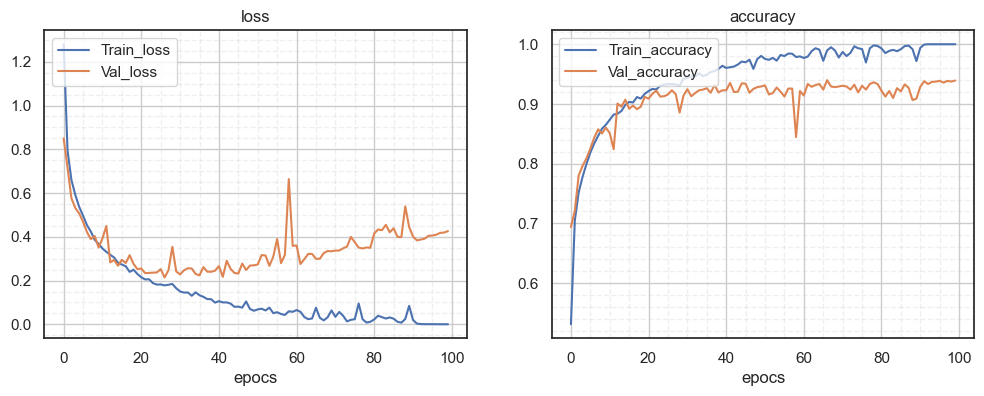

In [198]:
# 'CNN-64-MP-128-MP-32-D256'
evaluation_plots(classifier)

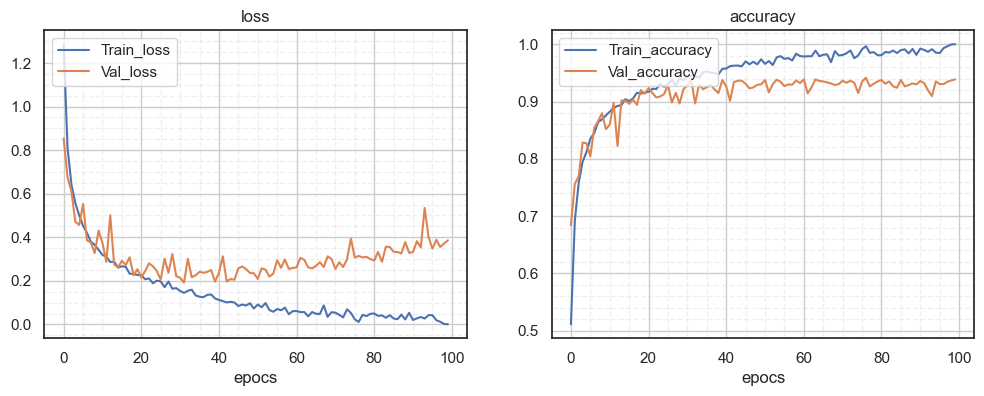

In [204]:
# 'CNN-128-MP-64-64-MP-32-32-MP-Flaten-128'
evaluation_plots(classifier)

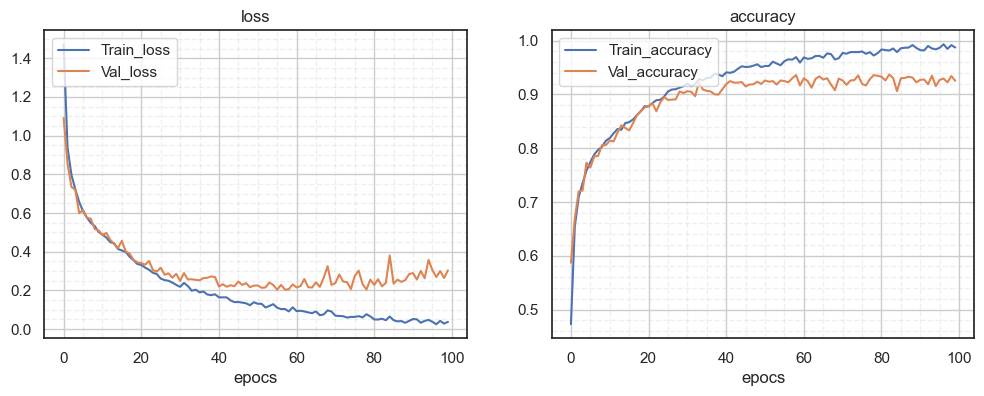

In [265]:
# CNN-128-MP-64-MP-64-MP-Flaten-D128'
evaluation_plots(classifier)

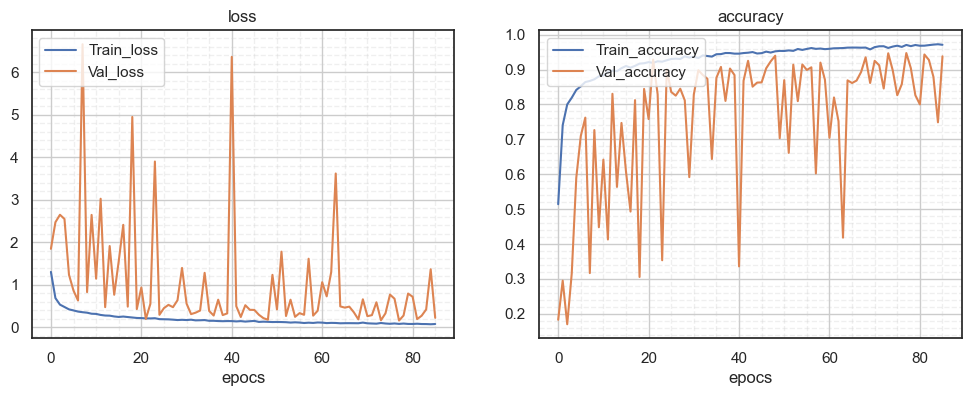

In [367]:
# CNN-128-MP-64-BN-MP-0.3-64-BN-MP-0.3-64-BN-MP-Flaten-D128-0.3-D64
evaluation_plots(classifier)

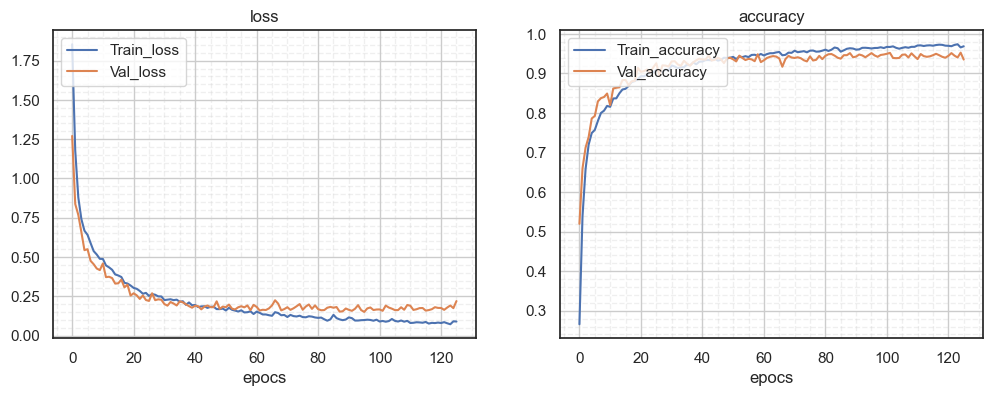

In [425]:
# 'CNN-128-MP-128-MP-0.3-64-MP-0.3-64-MP-Flaten-D128-0.3-D64_ES'
evaluation_plots(classifier)

In [426]:
est_cnn = estimator(classifier, class_names)    
predicted_labels_cnn = est_cnn.predict(X_test)

107/107 [==============================] - 0s 3ms/step


In [427]:
print(classification_report(y_test,predicted_labels_cnn ,digits=4,target_names=class_names))

                       precision    recall  f1-score   support

             basophil     0.9724    0.7213    0.8282       244
           eosinophil     0.9903    0.9856    0.9880       624
         erythroblast     0.9577    0.9453    0.9515       311
immature granulocytes     0.8172    0.8877    0.8510       579
           lymphocyte     0.8935    0.9671    0.9289       243
             monocyte     0.8366    0.9014    0.8678       284
           neutrophil     0.9783    0.9459    0.9618       666
             platelet     0.9979    0.9979    0.9979       470

             accuracy                         0.9322      3421
            macro avg     0.9305    0.9190    0.9219      3421
         weighted avg     0.9358    0.9322    0.9322      3421



107/107 [==============================] - 0s 2ms/step


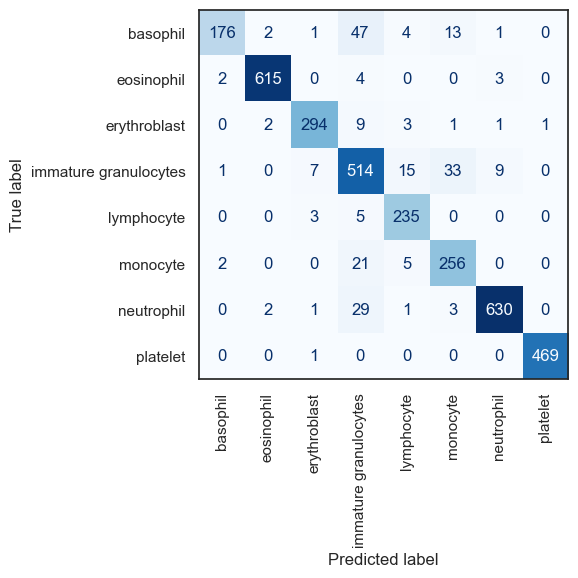

In [428]:
ConfusionMatrixDisplay.from_estimator(est_cnn,X_test,y_test,display_labels=class_names,cmap='Blues',colorbar=False,xticks_rotation=90)
plt.show()

## Diffirent Activation Functions

In [439]:
from tensorboard.plugins.hparams import api as hp

In [441]:
logdir = "logs/fit_cnn_hparam_tuning/"+ 'hparam_tuning'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1,write_graph=True) # Use it in fit, it saves data for each epoch

In [465]:
HP_Activation = hp.HParam('activation', hp.Discrete(['sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu','relu']))
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_Activation],metrics=[hp.Metric('accuracy', display_name='Accuracy')]
  )
def train_model(hparams,logdir,x_train, y_train,x_test, y_test):
    model = keras.Sequential(name='cnn_hparam_tuning')
    model.add(layers.Conv2D(128, kernel_size=(5, 5),padding='same', activation=hparams[HP_Activation],input_shape=(28,28,3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(128, kernel_size=(3, 3),padding='same', activation=hparams[HP_Activation]))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(64, kernel_size=(3, 3),padding='same', activation=hparams[HP_Activation]))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(64, kernel_size=(3, 3),padding='same', activation=hparams[HP_Activation]))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=hparams[HP_Activation]))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation=hparams[HP_Activation]))
    model.add(layers.Dense(8, activation='softmax'))
    
    model.compile(
      optimizer='Adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'])

    hist = model.fit(x_train, y_train, epochs=2,batch_size=128,validation_data=(X_val,y_val),callbacks=[tf.keras.callbacks.TensorBoard(logdir),hp.KerasCallback(logdir, hparams)]) 
    _, accuracy = model.evaluate(x_val, y_val)
    return accuracy

In [469]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_model(hparams,logdir,x_train, y_train,x_test, y_test)
        tf.summary.scalar('accuracy', accuracy, step=1)

In [470]:
session_name = HP_Activation.domain.values
for idx,optimizer in enumerate(HP_Activation.domain.values) :
    hparams = {
          HP_Activation: optimizer,
      }
    run_name = "run:{}".format(session_name[idx]) 
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/', hparams)

--- Starting trial: run:elu
{'activation': 'elu'}
Epoch 1/2
94/94 [==============================] - 3s 23ms/step - loss: 2.3765 - accuracy: 0.3436 - val_loss: 2.8505 - val_accuracy: 0.1694
Epoch 2/2
54/54 [==============================] - 0s 4ms/step - loss: 0.6303 - accuracy: 0.7675
--- Starting trial: run:relu
{'activation': 'relu'}
Epoch 1/2
94/94 [==============================] - 2s 23ms/step - loss: 2.5633 - accuracy: 0.2275 - val_loss: 2.0641 - val_accuracy: 0.1822
Epoch 2/2
54/54 [==============================] - 0s 3ms/step - loss: 1.2001 - accuracy: 0.5748
--- Starting trial: run:selu
{'activation': 'selu'}
Epoch 1/2
94/94 [==============================] - 2s 22ms/step - loss: 3.3048 - accuracy: 0.2929 - val_loss: 2.9655 - val_accuracy: 0.1694
Epoch 2/2
54/54 [==============================] - 0s 4ms/step - loss: 0.8924 - accuracy: 0.6343
--- Starting trial: run:sigmoid
{'activation': 'sigmoid'}
Epoch 1/2
94/94 [==============================] - 2s 22ms/step - loss: 2.019

In [464]:
%load_ext tensorboard
%tensorboard --logdir logs/fit_cnn_hparam_tuning

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20876), started 0:03:23 ago. (Use '!kill 20876' to kill it.)